In [12]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd  # Для создания таблицы результатов
import itertools  # Для генерации комбинаций углов бокса
import numpy as np

In [18]:
class LeastSquaresFitter:
    def __init__(self, func, learning_rate=0.01, max_iterations=1000, ensemble_method=None):
        """
        Инициализация класса.

        Parameters:
        func: callable
            Функция g, принимающая параметры a и массив x.
        learning_rate: float
            Скорость обучения для градиентного спуска.
        max_iterations: int
            Максимальное количество итераций для градиентного спуска.
        ensemble_method: str
            Метод ансамблирования ('bagging', 'boosting', 'stacking').
        """
        self.func = func
        self.coefficients = None
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.ensemble_method = ensemble_method
        self.model = None
        
    def create_boxes(self, bounds, num_boxes):
        """
        Функция для создания коробок в n-мерном пространстве.

        Parameters:
        bounds: list of tuples
            Пределы по каждой оси [(xmin, xmax), (ymin, ymax), ...].
        num_boxes: int
            Количество коробок по каждой оси.

        Returns:
        boxes: list
            Список коробок.
        """
        dimensions = len(bounds)
        edges = []
        for dim in range(dimensions):
            min_val, max_val = bounds[dim]
            edges.append(np.linspace(min_val, max_val, num_boxes + 1))

        # Создаем сетку индексов для всех комбинаций коробок
        indices = np.indices([num_boxes]*dimensions).reshape(dimensions, -1).T

        boxes = []
        for index in indices:
            box = []
            for dim, idx in enumerate(index):
                box.append((edges[dim][idx], edges[dim][idx+1]))
            boxes.append(box)
        return boxes

    def generate_points(self, f, bounds, num_boxes, m_total, a_true, method='adaptive'):
        """
        Генерация точек для функции f(x) с выбранным методом.

        Parameters:
        f: callable
            Функция для генерации значений y.
        bounds: list of tuples
            Пределы по каждой оси [(xmin, xmax), (ymin, ymax), ...].
        num_boxes: int
            Количество коробок по каждой оси (только для адаптивного метода).
        m_total: int
            Общее количество точек.
        a_true: np.array
            Истинные коэффициенты.
        method: str
            Метод генерации точек ('random' или 'adaptive').

        Returns:
        points: np.array
            Сгенерированные факторы (входные данные x).
        values: np.array
            Значения функции на этих точках (целевые значения y).
        """
        if method == 'adaptive':
            # Используем адаптивный алгоритм
            boxes = self.create_boxes(bounds, num_boxes)
            num_boxes_total = len(boxes)
            changes = []

            # Оценка изменений функции в каждой коробке
            for box in boxes:
                # Получаем min и max по каждой оси для текущего бокса
                mins = []
                maxs = []
                for (min_val, max_val) in box:
                    mins.append(min_val)
                    maxs.append(max_val)
                # Генерируем все комбинации мин и макс для получения углов бокса
                corners = list(itertools.product(*zip(mins, maxs)))
                corners = np.array(corners)
                # Вычисляем значения функции в углах бокса
                values_at_corners = f(corners, a_true)
                # Оцениваем изменение функции в боксе
                change = np.max(values_at_corners) - np.min(values_at_corners)
                # Добавляем изменение в список изменений
                changes.append(change)

            # Нормализация изменений
            total_change = np.sum(changes)
            if total_change == 0:
                # Если все изменения равны нулю, распределяем точки равномерно
                normalized_changes = [1 / num_boxes_total] * num_boxes_total
            else:
                normalized_changes = [change / total_change for change in changes]

            # Генерация точек пропорционально изменениям
            all_points = []
            all_values = []

            for i, box in enumerate(boxes):
                num_points_in_box = max(1, int(m_total * normalized_changes[i]))  # Гарантируем хотя бы 1 точку
                # Генерируем точки внутри бокса
                points_in_box = []
                for (min_val, max_val) in box:
                    points_in_box.append(np.random.uniform(min_val, max_val, num_points_in_box))
                points_in_box = np.column_stack(points_in_box)
                values = f(points_in_box, a_true)
                all_points.append(points_in_box)
                all_values.append(values)

            return np.vstack(all_points), np.concatenate(all_values)

        elif method == 'random':
            # Полностью случайная генерация точек
            dimensions = len(bounds)
            points = []
            for (min_val, max_val) in bounds:
                points.append(np.random.uniform(min_val, max_val, m_total))
            points = np.column_stack(points)
            values = f(points, a_true)
            return points, values

        else:
            raise ValueError(f"Неизвестный метод генерации точек: {method}")

    def fit(self, x, y):
        """
        Подбор коэффициентов методом градиентного спуска или ансамблирования.

        Parameters:
        x: np.array
            Входные данные.
        y: np.array
            Целевые значения.
        """
        if self.ensemble_method is None:
            # Обычный градиентный спуск
            a = np.zeros(x.shape[1])
            for iteration in range(self.max_iterations):
                grad = self.gradient(a, x, y)
                a -= self.learning_rate * grad

                if np.linalg.norm(grad) < 1e-6:
                    print(f"Градиентный спуск сошелся за {iteration} итераций.")
                    break

            self.coefficients = a
        else:
            # Ансамблирование
            if self.ensemble_method == 'bagging':
                base_model = DecisionTreeRegressor()
                self.model = BaggingRegressor(estimator=base_model, n_estimators=10, random_state=42)
            elif self.ensemble_method == 'boosting':
                self.model = GradientBoostingRegressor(n_estimators=100, learning_rate=self.learning_rate, max_depth=3, random_state=42)
            elif self.ensemble_method == 'stacking':
                estimators = [
                    ('lr', LinearRegression()),
                    ('dt', DecisionTreeRegressor())
                ]
                self.model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
            else:
                raise ValueError(f"Неизвестный метод ансамблирования: {self.ensemble_method}")

            self.model.fit(x, y)

    def predict(self, x):
        """
        Предсказание значений y по входным данным x.

        Parameters:
        x: np.array
            Входные данные.

        Returns:
        np.array
            Предсказанные значения y.
        """
        if self.ensemble_method is None:
            if self.coefficients is None:
                raise ValueError("Модель не обучена. Сначала вызовите метод fit.")
            return self.func(self.coefficients, x)
        else:
            if self.model is None:
                raise ValueError("Модель не обучена. Сначала вызовите метод fit.")
            return self.model.predict(x)

    def evaluate(self, x, y, criterion='MSE'):
        """
        Оценка точности модели по заданному критерию.

        Parameters:
        x: np.array
            Входные данные.
        y: np.array
            Целевые значения.
        criterion: str
            Критерий оценки ('MSE', 'MAE', 'R2').

        Returns:
        float
            Значение выбранной метрики.
        """
        predictions = self.predict(x)

        if criterion == 'MSE':
            metric_value = mean_squared_error(y, predictions)
        elif criterion == 'MAE':
            metric_value = mean_absolute_error(y, predictions)
        elif criterion == 'R2':
            metric_value = r2_score(y, predictions)
        else:
            raise ValueError(f"Неизвестный критерий оценки: {criterion}")

        return metric_value

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Определяем функцию g, которую будем подбирать
    def g(a, x):
        return np.dot(x, a) + np.sum(x ** 2, axis=1) ** 2

    # Определяем функцию f, описывающую резкое возрастание и провал
    def f(x, a_true):
        return (np.dot(x, a_true) +
               np.sum(x ** 2, axis=1) +
               np.sum(x ** 3, axis=1) +
               np.sum(x ** 4, axis=1))

    # Задаем истинные коэффициенты
    true_coefficients = np.array([2.5, -1.2])

    # Параметры эксперимента
    methods = ['adaptive', 'random']
    num_boxes_list = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # Только для метода 'adaptive'
    bounds = [(0, 1), (0, 1)]
    m_total_train = 5000
    m_total_test = 1000

    # Генерируем тестовый набор данных один раз
    fitter = LeastSquaresFitter(func=g, learning_rate=0.01, max_iterations=10000, ensemble_method='boosting')
    x_test, y_test = fitter.generate_points(
        f, bounds, num_boxes=None, m_total=m_total_test, a_true=true_coefficients, method='random'
    )

    results = []

    for method in methods:
        if method == 'adaptive':
            for num_boxes in num_boxes_list:
                # Генерируем обучающие данные
                x_train, y_train = fitter.generate_points(
                    f, bounds, num_boxes=num_boxes, m_total=m_total_train, a_true=true_coefficients, method=method
                )
                for i in ['bagging', 'boosting','stacking']:
                    # Создаем и обучаем модель
                    current_fitter = LeastSquaresFitter(func=g, learning_rate=0.01, max_iterations=10000, ensemble_method=i)
                    current_fitter.fit(x_train, y_train)
                    # Оценка метрик
                    metrics = {criterion: current_fitter.evaluate(x_test, y_test, criterion=criterion) 
                               for criterion in ['MSE', 'MAE', 'R2']}
                    # Сохраняем результаты
                    results.append({
                        'method': method + ' ' + i,
                        'num_boxes': num_boxes,
                        **metrics
                    })
        else:  # метод 'random'
            # Генерируем обучающие данные
            x_train, y_train = fitter.generate_points(
                f, bounds, num_boxes=None, m_total=m_total_train, a_true=true_coefficients, method=method
            )
            for i in ['bagging', 'boosting','stacking']:
                # Создаем и обучаем модель
                current_fitter = LeastSquaresFitter(func=g, learning_rate=0.01, max_iterations=10000, ensemble_method=i)
                current_fitter.fit(x_train, y_train)
                # Оценка метрик
                metrics = {criterion: current_fitter.evaluate(x_test, y_test, criterion=criterion) 
                           for criterion in ['MSE', 'MAE', 'R2']}
                # Сохраняем результаты
                results.append({
                    'method': method + ' ' + i,
                    'num_boxes': None,
                    **metrics
                })

In [24]:
# Создаем DataFrame с результатами
df_results = pd.DataFrame(results)
print("\nТаблица результатов:")
df_results


Таблица результатов:


,method,num_boxes,MSE,MAE,R2
0,adaptive bagging,1.0,0.000764,0.018183,0.999715
1,adaptive boosting,1.0,0.450453,0.550381,0.831995
2,adaptive stacking,1.0,0.002418,0.032494,0.999098
3,adaptive bagging,2.0,0.000731,0.019184,0.999727
4,adaptive boosting,2.0,0.501948,0.592019,0.812789
5,adaptive stacking,2.0,0.002057,0.033002,0.999233
6,adaptive bagging,4.0,0.000622,0.018350,0.999768
7,adaptive boosting,4.0,0.542132,0.616250,0.797802
8,adaptive stacking,4.0,0.031927,0.155414,0.988092
9,adaptive bagging,8.0,0.000576,0.018281,0.999785


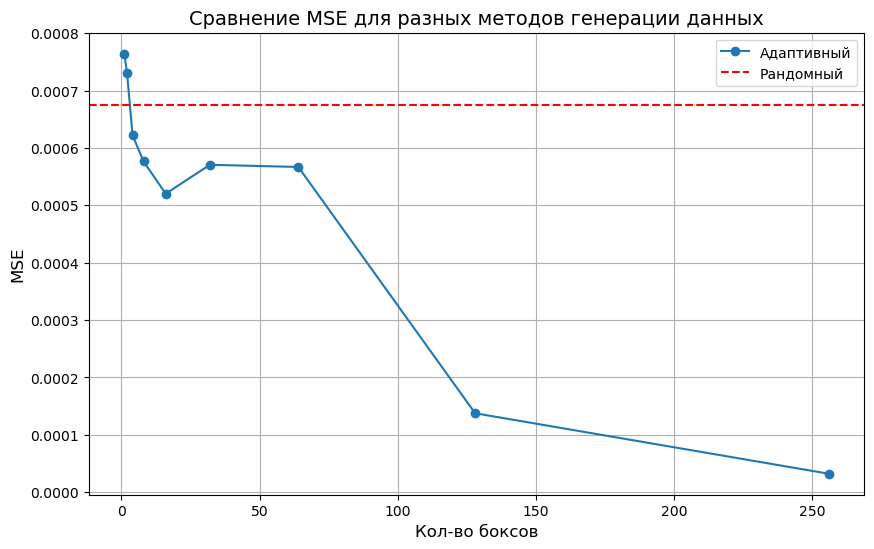

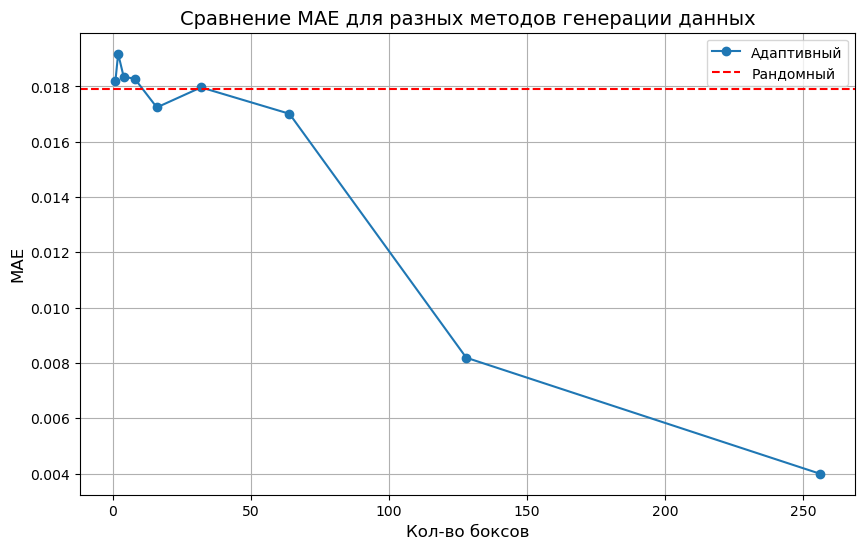

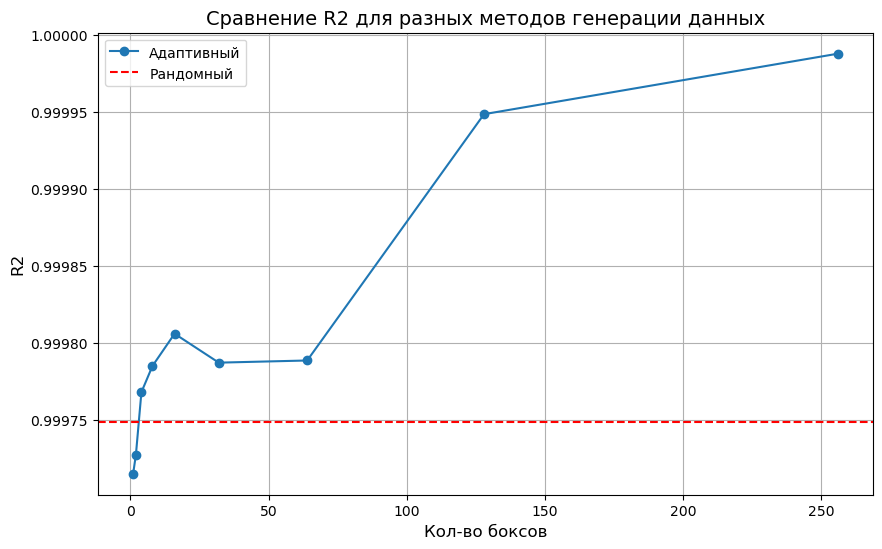

In [25]:
# Визуализация результатов
adaptive_data = df_results[df_results['method'] == 'adaptive bagging']
random_data = df_results[df_results['method'] == 'random bagging']

metrics = ['MSE', 'MAE', 'R2']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(adaptive_data['num_boxes'], adaptive_data[metric], marker='o', linestyle='-', label='Адаптивный')
    plt.axhline(y=random_data[metric].values[0], color='r', linestyle='--', label='Рандомный')
    plt.xlabel('Кол-во боксов', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.title(f'Сравнение {metric} для разных методов генерации данных', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Определяем функцию g, которую будем подбирать
    def g(a, x):
        return np.dot(x, a) + np.sum(x ** 2, axis=1) ** 2

    # Определяем функцию f, описывающую резкое возрастание и провал
    def f(x, a_true):
        return (np.dot(x, a_true) +
               np.sum(x ** 2, axis=1) +
               np.sum(x ** 3, axis=1) +
               np.sum(x ** 4, axis=1))

    # Задаем истинные коэффициенты
    true_coefficients = np.array([2.5, -1.2])

    # Параметры эксперимента
    methods = ['adaptive', 'random']
    num_boxes_list = [1,2, 4, 8, 16, 32, 64, 128, 256]  # Только для метода 'adaptive'
    ensemble_methods = ['bagging', 'boosting', 'stacking']  # Добавленные методы
    bounds = [(0, 1), (0, 1)]
    m_total_train = 5000
    m_total_test = 1000

    # Генерируем тестовый набор данных один раз
    fitter = LeastSquaresFitter(func=g, learning_rate=0.01, max_iterations=10000, ensemble_method='boosting')
    x_test, y_test = fitter.generate_points(
        f, bounds, num_boxes=None, m_total=m_total_test, a_true=true_coefficients, method='random'
    )

    results = []

    for method in methods:
        if method == 'adaptive':
            for num_boxes in num_boxes_list:
                for ensemble_method in ensemble_methods:  # Цикл по методам ансамбля
                    # Генерируем обучающие данные
                    x_train, y_train = fitter.generate_points(
                        f, bounds, num_boxes=num_boxes, m_total=m_total_train, a_true=true_coefficients, method=method
                    )
                    # Создаем и обучаем модель с текущим методом ансамбля
                    current_fitter = LeastSquaresFitter(
                        func=g, 
                        learning_rate=0.01, 
                        max_iterations=10000, 
                        ensemble_method=ensemble_method  # Используем текущий метод
                    )
                    current_fitter.fit(x_train, y_train)
                    # Оценка метрик
                    metrics = {criterion: current_fitter.evaluate(x_test, y_test, criterion=criterion) 
                               for criterion in ['MSE', 'MAE', 'R2']}
                    # Сохраняем результаты
                    results.append({
                        'method': method,
                        'ensemble_method': ensemble_method,
                        'num_boxes': num_boxes,
                        **metrics
                    })
        else:  # метод 'random'
            for ensemble_method in ensemble_methods:  # Цикл по методам ансамбля
                # Генерируем обучающие данные
                x_train, y_train = fitter.generate_points(
                    f, bounds, num_boxes=None, m_total=m_total_train, a_true=true_coefficients, method=method
                )
                # Создаем и обучаем модель с текущим методом ансамбля
                current_fitter = LeastSquaresFitter(
                    func=g, 
                    learning_rate=0.01, 
                    max_iterations=10000, 
                    ensemble_method=ensemble_method  # Используем текущий метод
                )
                current_fitter.fit(x_train, y_train)
                # Оценка метрик
                metrics = {criterion: current_fitter.evaluate(x_test, y_test, criterion=criterion) 
                           for criterion in ['MSE', 'MAE', 'R2']}
                # Сохраняем результаты
                results.append({
                    'method': method,
                    'ensemble_method': ensemble_method,
                    'num_boxes': None,
                    **metrics
                })


Таблица результатов:
  method ensemble_method  num_boxes      MSE      MAE       R2
adaptive         bagging        1.0 0.000837 0.019252 0.999663
adaptive        boosting        1.0 0.427040 0.528792 0.828017
adaptive        stacking        1.0 0.002279 0.032571 0.999082
adaptive         bagging        2.0 0.000808 0.019300 0.999674
adaptive        boosting        2.0 0.471593 0.572699 0.810075
adaptive        stacking        2.0 0.002000 0.031618 0.999195
adaptive         bagging        4.0 0.000606 0.018512 0.999756
adaptive        boosting        4.0 0.504919 0.595474 0.796653
adaptive        stacking        4.0 0.025657 0.135699 0.989667
adaptive         bagging        8.0 0.000609 0.018362 0.999755
adaptive        boosting        8.0 0.512390 0.600671 0.793644
adaptive        stacking        8.0 0.020931 0.119312 0.991571
adaptive         bagging       16.0 0.000716 0.018777 0.999712
adaptive        boosting       16.0 0.521877 0.604372 0.789824
adaptive        stacking       16

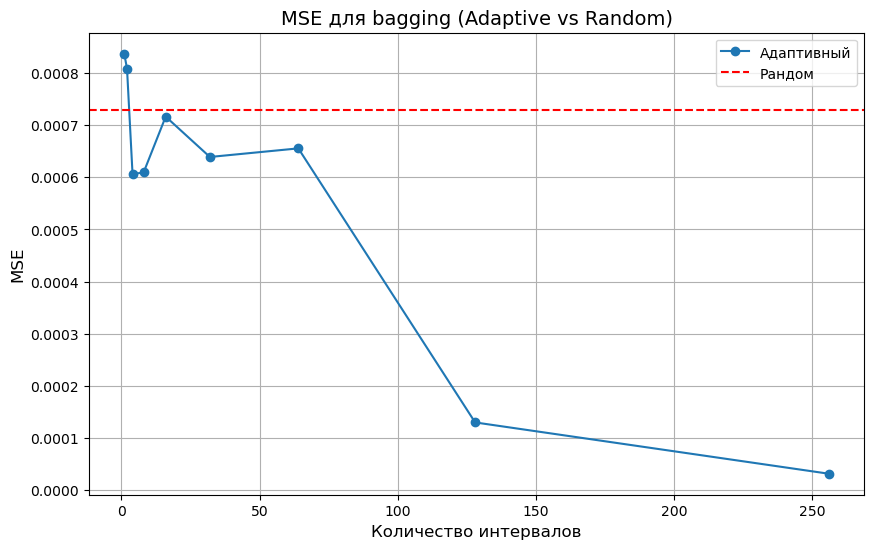

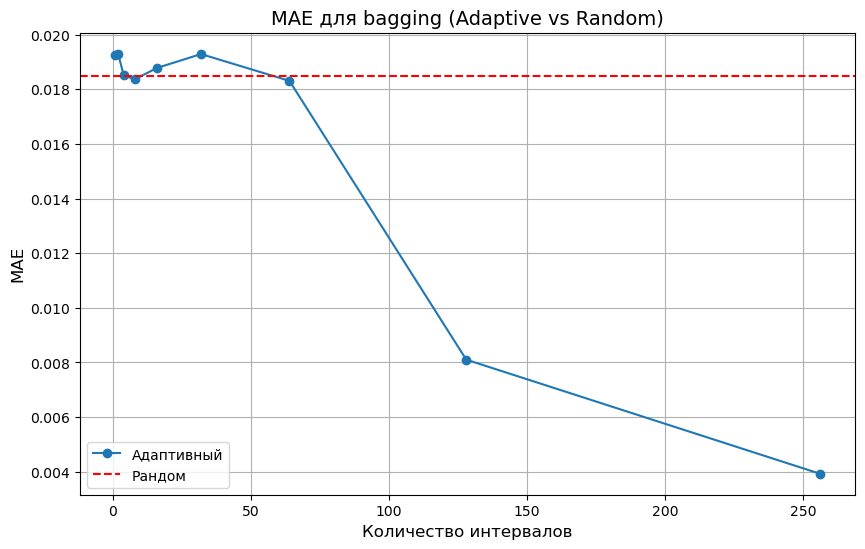

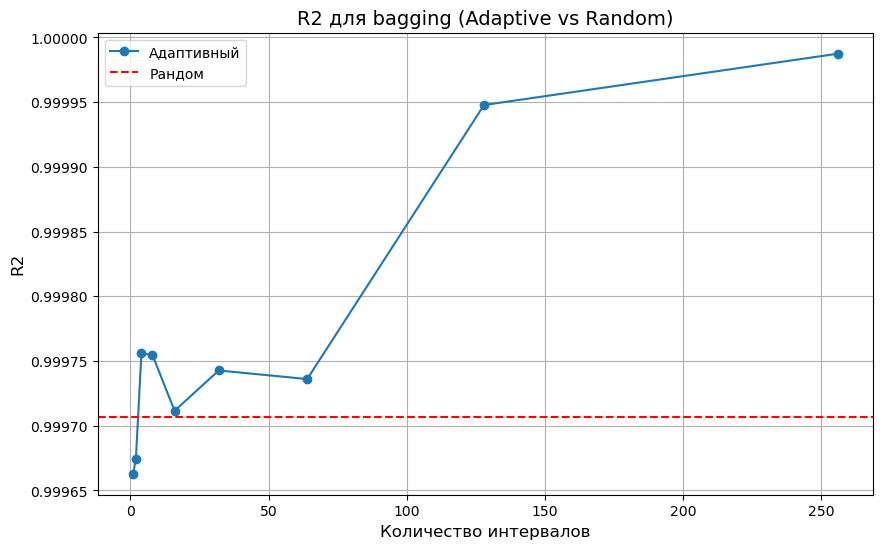

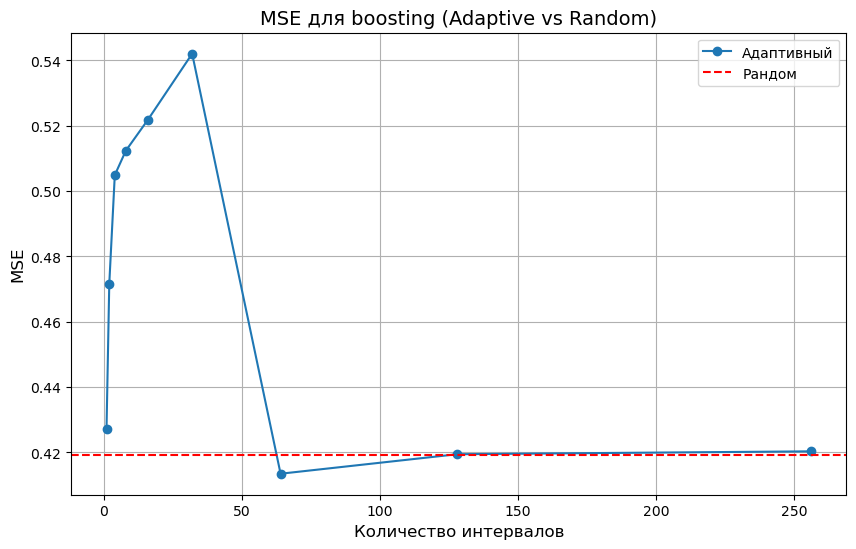

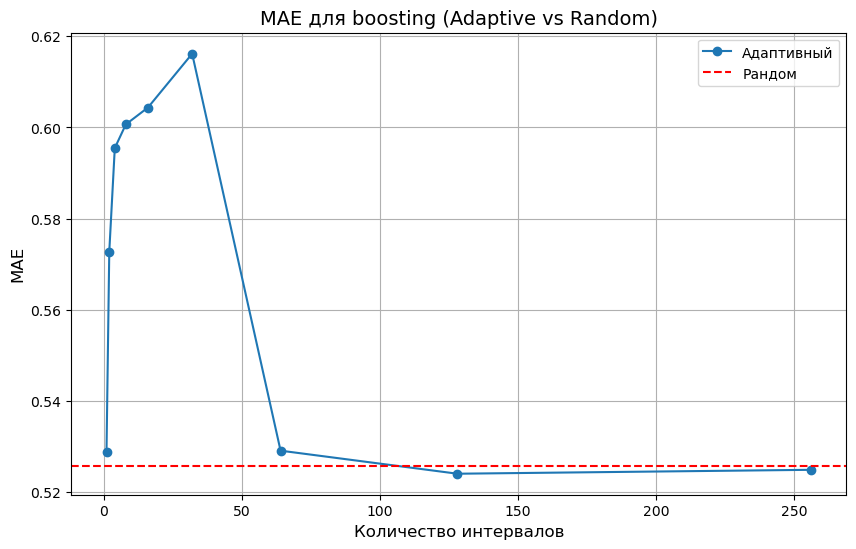

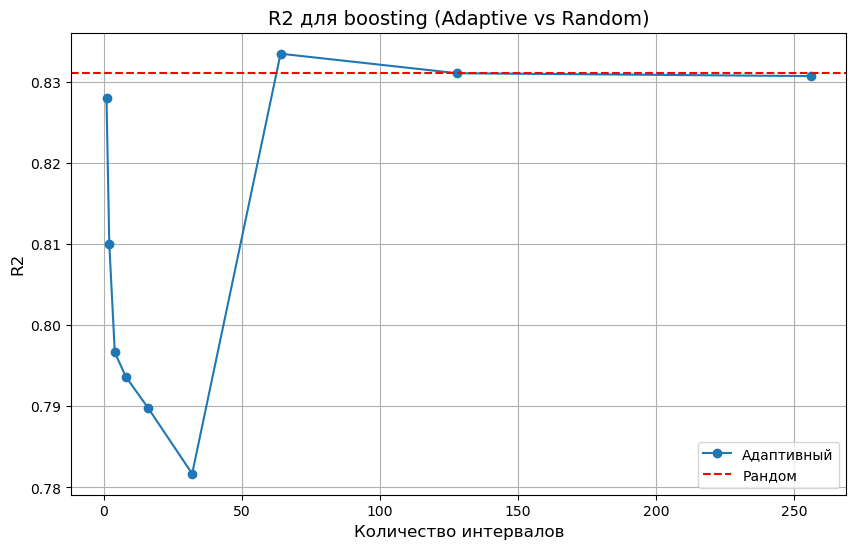

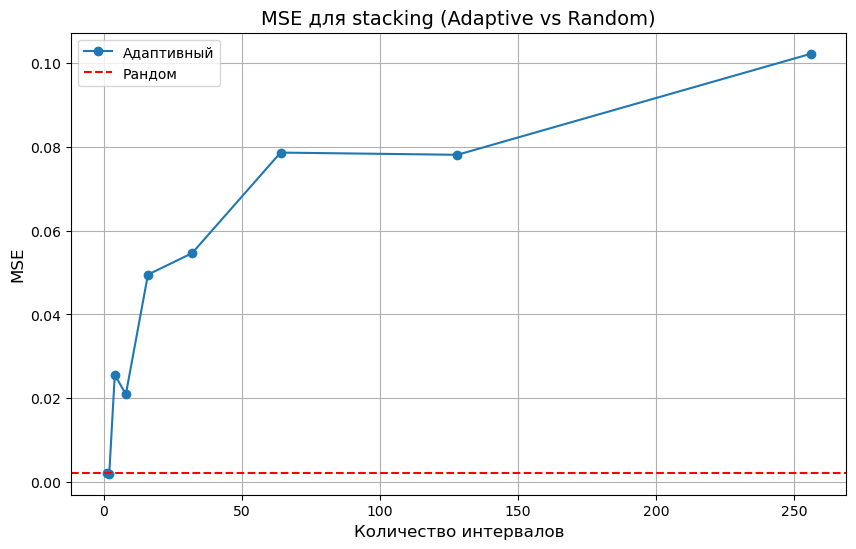

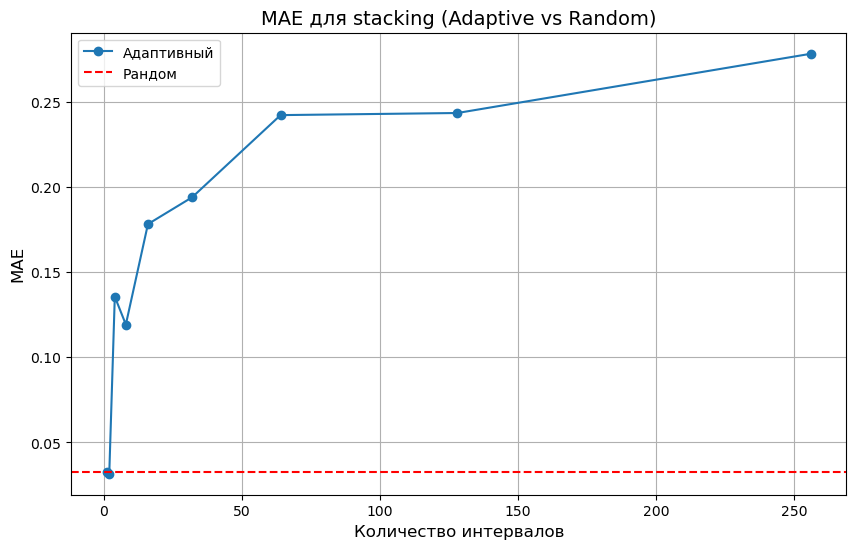

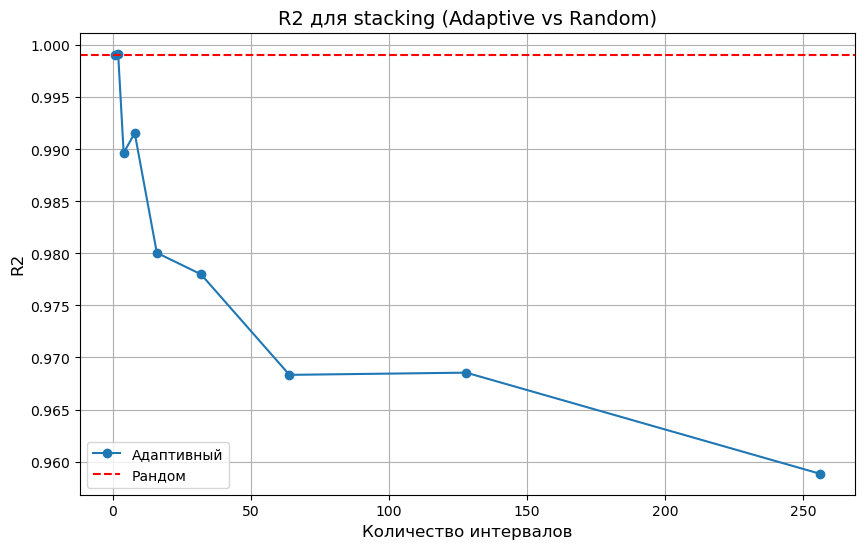

In [32]:
# Создаем DataFrame с результатами
df_results = pd.DataFrame(results)
print("\nТаблица результатов:")
print(df_results.to_string(index=False))

# Визуализация результатов для каждого метода ансамбля
metrics = ['MSE', 'MAE', 'R2']
for ensemble_method in ensemble_methods:
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        # Фильтрация данных для adaptive метода и текущего ансамбля
        adaptive_data = df_results[
            (df_results['method'] == 'adaptive') & 
            (df_results['ensemble_method'] == ensemble_method)
        ]
        plt.plot(
            adaptive_data['num_boxes'], 
            adaptive_data[metric], 
            marker='o', 
            linestyle='-', 
            label='Адаптивный'
        )
        
        # Фильтрация данных для random метода и текущего ансамбля
        random_data = df_results[
            (df_results['method'] == 'random') & 
            (df_results['ensemble_method'] == ensemble_method)
        ]
        random_value = random_data[metric].values[0]
        plt.axhline(
            y=random_value, 
            color='r', 
            linestyle='--', 
            label='Рандом'
        )
        
        # Настройки графика
        plt.xlabel('Количество интервалов', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.title(
            f'{metric} для {ensemble_method} (Adaptive vs Random)', 
            fontsize=14
        )
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{metric} для {ensemble_method} (Adaptive vs Random).png')
        plt.show()
        